## Pitch Control

Pitch control at a given location is the probability that a player (or team) will gain control of the ball if it moves directly in that location.\
Pitch control tries to answer the question:"What options are available to the player with the ball?"\
Pitch control models enables one to qauntify the passing options directly\
 
### Building a pitch control model
For a given position on the pitch:

1. How long will it take for the ball to arrive?
2. How long will it take for each player to arrive?
3. What is the total probability that each team will control the ball after it has arrived?

Repeat calculation for all locations on the pitch

### Player time to arrival
Given their initial positions and velocity how fast can a player get to any other position on the pitch?\
  
Key assumptions:
1. Players have a maximum speed: 5 m/s
2. Players have a maximum acceleration: 7m/s/s
3. Players take the fastest possible path

### Simple approximation for arrival time
Two step process
1. There is an initial "reaction time" of 0.7 seconds. During this time each player continues along with their current trajectory
2. After 0.7 seconds, the player runs directly towards the target location at their maximum speed of 5 m/s

## Import Dependencies and Read in Data

In [32]:
import pandas as pd
import numpy as np
import nbimporter
import matplotlib.pyplot as plt
import Analyzing_Player_Motion as APM
import Football_Analytics as FA
import Pitch_Control_Model as MPC


In [28]:
DATADIR2 = r"C:\Users\MustaphaM\Desktop\sample-data-master\data\Sample_Game_2\Sample_Game_2_RawEventsData.csv"

#read in the events data
events = pd.read_csv(DATADIR2)

#read in the tracking data
DataDir= r"C:\Users\MustaphaM\Desktop\sample-data-master\data"
tracking_Hom = APM.tracking_data(DataDir, 2, "Home")
tracking_Awa = APM.tracking_data(DataDir,2,"Away")

#Convert positions from metrica units to meters
tracking_HomeConv = tracking_Hom.copy()
tracking_AwayConv = tracking_Awa.copy()

tracking_home = APM.to_metric_coordinates(tracking_HomeConv)
tracking_away = APM.to_metric_coordinates(tracking_AwayConv)
events = APM.to_metric_coordinates(events)

#reverse direction of play in the second half so that home team is always attacking from right -> left
tracking_home, tracking_away, events = APM.to_single_playing_direction(tracking_home, tracking_away, events)

Reading team: home
Reading team: away


## Calculate Player Velocities

In [29]:
tracking_home = APM.calc_player_velocities(tracking_home, smoothing = True)
tracking_away = APM.calc_player_velocities(tracking_away, smoothing = True)

## Taking a Look at the Passes Leading up to the Second Goal

In [30]:
shots = events[events["Type"]== "SHOT"]
goals = shots[shots["Subtype"].str.contains("-GOAL")].copy()
goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xf1c0624d88>)

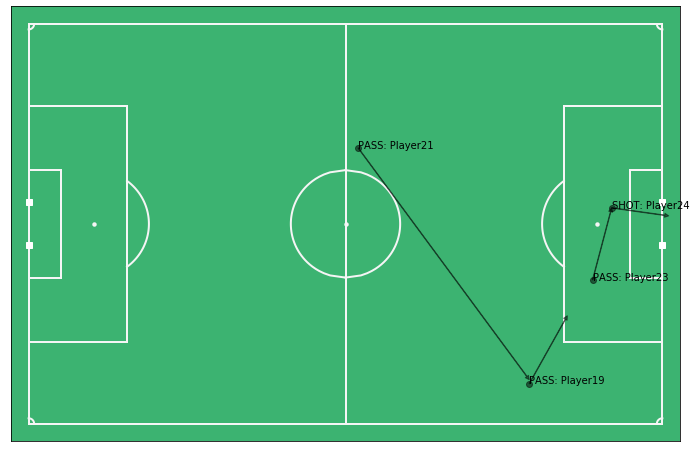

In [31]:
plot_events(events.loc[820:823], color ="k", indicators = ["Marker", "Arrow"], annotate = True)

## Pitch Control for Passes leading up to Goal 2

In [34]:
#first get model parameters
params = MPC.default_model_params(3)
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

In [56]:
def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
    return fig,ax

def plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (106.0,68)):
    """ plot_pitchcontrol_for_event( event_id, events,  tracking_home, tracking_away, PPCF )
    
    Plots the pitch control surface at the instant of the event given by the event_id. Player and ball positions are overlaid.
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    NB: this function no longer requires xgrid and ygrid as an input
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """    

    # pick a pass at which to generate the pitch control surface
    pass_frame = events.loc[event_id]['Start Frame']
    pass_team = events.loc[event_id].Team
    
    # plot frame and event
    fig,ax = plot_pitch(field_color='white', field_dimen = field_dimen)
    plot_frame( tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
    
    # plot pitch control surface
    if pass_team=='Home':
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)

    return fig,ax
def find_goalkeeper(team):
    '''
    Find the goalkeeper in team, identifying him/her as the player closest to goal at kick off
    ''' 
    x_columns = [c for c in team.columns if c[-2:].lower()=='_x' and c[:4] in ['Home','Away']]
    GK_col = team.iloc[0][x_columns].abs().idxmax(axis=1)
    return GK_col.split('_')[1]

In [69]:
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

<IPython.core.display.Javascript object>


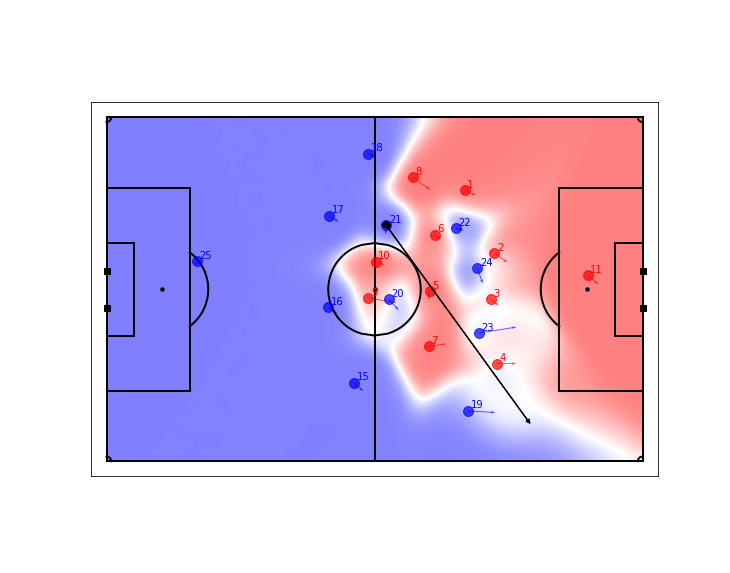

(<Figure size 960x640 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xf1c14e1448>)

In [70]:
GK_numbers = [find_goalkeeper(tracking_home),find_goalkeeper(tracking_away)] #find goal keepers for offside calculations
PPCF,xgrid,ygrid = MPC.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)

plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, annotate=True )


Player 21 makes the long pass out to the right wing. It was a pass to the blue region meaning the blue team were likely to retain the ball.\
Also there is about 60.8% chance that the pass will be successful. If the had passed the ball to the blue portion, it will be about 100 percent certain for them to retain control, however, if they had passed it to the red portion, then, it will be next to impossible for them to retain the possession.

<IPython.core.display.Javascript object>


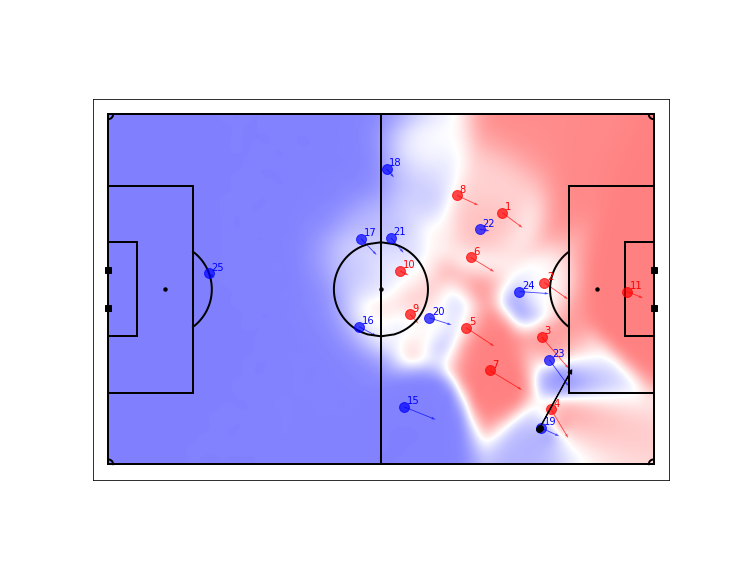

(<Figure size 960x640 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xf1c1dd6dc8>)

In [71]:
#second pass
PPCF,xgrid,ygrid = MPC.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, annotate=True )

The probability that the pass is successful is about 75.8 percent, hence there is nearly about 4/5 that control will be retained. The opportunity to pass there was made possible by the run made by player 23

<IPython.core.display.Javascript object>


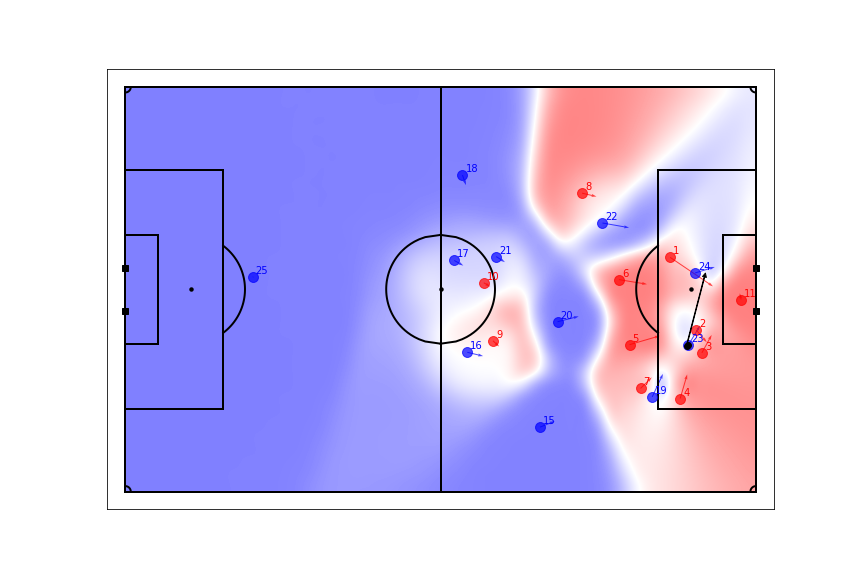

(<Figure size 960x640 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xf1c58a5488>)

In [72]:
#third pass
PPCF,xgrid,ygrid = MPC.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, annotate=True )

The probability that the pass is successful is about 60%. The pass provides a clear shot-on-goal for player 24

## Calculating the Probability for Every Home Team Successful Pass

In [74]:
#calculates the probability of success for every home team successful pass at moment the pass was made
#we are only considering the complete passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]
home_passes.shape

(543, 14)

There are 543 such passes

### Storing Pass Success Probabilities

In [79]:
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = MPC.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
    defending_players = MPC.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
    Patt,Pdef = MPC.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )

### Making a Histogram for the Pass Sucesss Probability

<IPython.core.display.Javascript object>


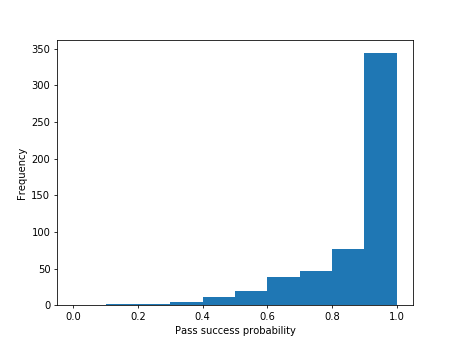

Text(0, 0.5, 'Frequency')

In [82]:
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency') 

Most of the passes made by the home team were more than 90 percent likely to be successful.\
20 - 30 passes had less than 50 percent success probability

### Looking at the Risky Passes

In [86]:
risky_passes = events.loc[[p[0] for p in pass_success_probability if p[1]<0.5]]
risky_passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
29,Home,PASS,NaN,1,1489,59.56,1578,63.12,Player11,Player9,53.00,10.20,9.54,24.48
93,Home,PASS,NaN,1,5372,214.88,5400,216.00,Player4,Player10,-1.06,-20.40,-23.32,-9.52
197,Home,PASS,CROSS,1,12180,487.20,12202,488.08,Player1,Player10,-40.28,19.72,-47.70,-3.40
251,Home,PASS,NaN,1,16388,655.52,16435,657.40,Player9,Player10,-13.78,0.68,-33.92,11.56
332,Home,PASS,DEEP BALL,1,20940,837.60,21022,840.88,Player4,Player10,-1.06,-13.60,-42.40,-17.00
512,Home,PASS,NaN,1,33376,1335.04,33427,1337.08,Player4,Player7,16.96,-19.72,-18.02,-20.40
566,Home,PASS,NaN,1,38287,1531.48,38318,1532.72,Player4,Player7,28.62,-34.00,14.84,-30.60
737,Home,PASS,HEAD,1,49065,1962.60,49105,1964.20,Player3,Player6,28.62,-16.32,21.20,-10.20
797,Home,PASS,NaN,1,51510,2060.40,51526,2061.04,Player9,Player10,-33.92,-13.60,-36.04,-7.48
813,Home,PASS,NaN,1,52620,2104.80,52692,2107.68,Player4,Player10,31.80,-18.36,0.00,6.80


<IPython.core.display.Javascript object>


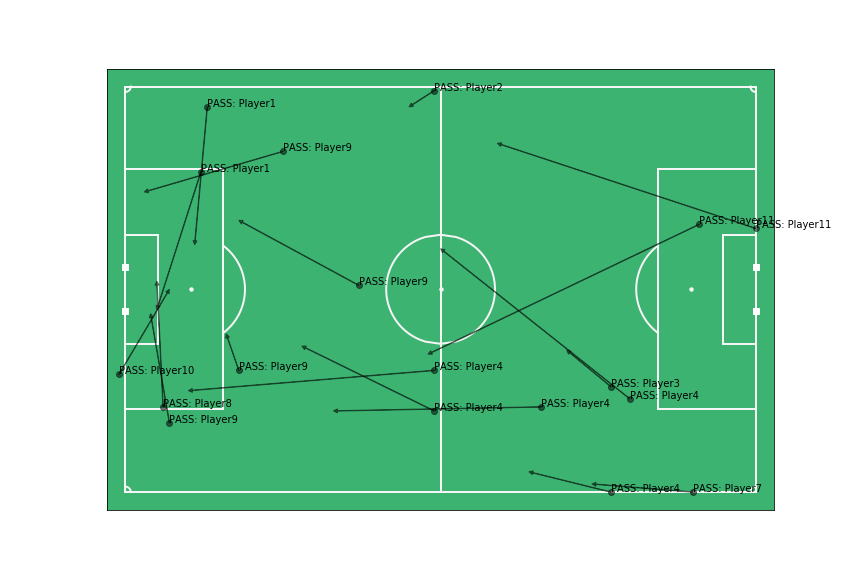

(<Figure size 960x640 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xf1c0950208>)

In [91]:
#plot the risky passes
FA.plot_events(risky_passes, color ='k', indicators = ["Marker", "Arrow"], annotate = True)

Observations: 1. Very long passes had lower probability of success
              2. Also, passes into crowded locations

In [92]:
#What happened following the risky passes?

print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )



Event following a risky (completed) pass
0.9761786746948964 PASS
0.31160841865474626 CHALLENGE
0.7518055328493835 BALL LOST
0.6643544450943134 PASS
0.9336350554716212 PASS
0.9901257167861145 PASS
0.9714052407449258 PASS
0.9751056048813957 PASS
0.9836812077003456 PASS
0.5147228904616257 PASS
0.9096298019133129 BALL LOST
1.0 PASS
0.9904149555663557 PASS
0.9760395733280377 PASS
0.6407971367135854 PASS
0.9245990067088163 PASS
0.7757401155735683 PASS
0.9914749443239345 PASS
0.9823808029823321 PASS
0.7731927881262496 PASS
